### Mini-projeto LSTMs

Grupo:
Caio Possidio
Felipe Neiva
,
Frederick Almeida
,
Ian Braga
,
Rubens Lima,

In [1]:
# pre processamento de dados
import pandas as pd
import numpy as np

# deep learning framework
import torch
from torch import nn, optim
import torch.nn.functional as F

# scalers e métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# plotting e visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\rubin\AppData\Local\Temp\ipykernel_38684\3385938965.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# utilizar cuda para acelerar o treinamento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Carregando o dataset

In [3]:
df = pd.read_csv('btc.csv', index_col='Date', parse_dates=True)
df.head()

,Symbol,Open,High,Low,Close,Volume From,Volume To
Date,,,,,,,
2018-05-26,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
2018-05-25,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2018-05-24,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
2018-05-23,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
2018-05-22,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [4]:
# removendo a coluna symbol
df.drop(columns=['Symbol'], inplace=True)
df.sort_values(by='Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume From,Volume To
Date,,,,,,
2014-12-01,300.0,370.0,300.00,370.0,0.05656,19.53
2014-12-02,370.0,378.0,370.00,378.0,15.01000,5675.07
2014-12-03,378.0,378.0,377.01,378.0,0.54660,206.52
2014-12-04,378.0,378.0,377.10,377.1,0.01000,3.77
2014-12-05,377.1,377.1,377.10,377.1,0.00000,0.00


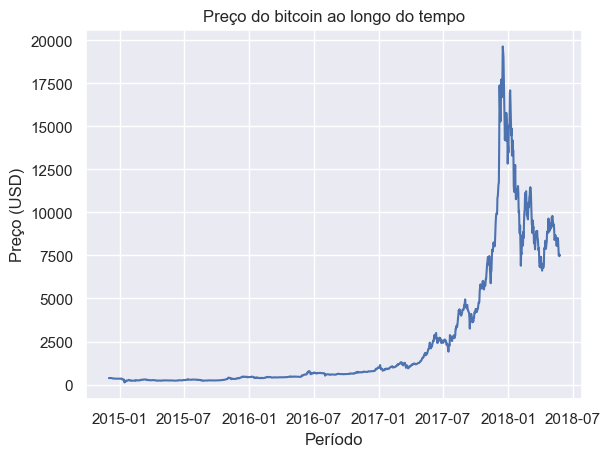

In [5]:
plt.plot(df.Close)
plt.xlabel("Período")
plt.ylabel("Preço (USD)")
plt.title("Preço do bitcoin ao longo do tempo")
plt.show()

In [6]:
# separando features e labels
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((1273, 5), (1273,))

In [7]:
# normalizando os dados
mm = MinMaxScaler()
ss = StandardScaler()

X_scaled = ss.fit_transform(X)
y_scaled = mm.fit_transform(y.reshape(-1, 1))

In [8]:
# define a quantidade de dias que vamos usar para fazer a previsão (n_steps_in) e a quantidade de dias que serão previstos (n_steps_out)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # encontra o final das sequências de input e output
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences): break
        # coleta input_sequence e output_sequence
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

# utilizando 100 dias por instancia p treinar, prevendo 50 dias
X_ss, y_mm = split_sequences(X_scaled, y_scaled, 100, 50)
print(X_ss.shape, y_mm.shape)

(1125, 100, 5) (1125, 50)


In [9]:
X_ss[0]

array([[-0.58087524, -0.56218474, -0.58526647, -1.03228266, -0.42210713],
       [-0.56238099, -0.56016332, -0.5655982 , -1.0307777 , -0.42205355],
       [-0.56026736, -0.56016332, -0.56362856, -1.03223334, -0.42210536],
       [-0.56026736, -0.56016332, -0.56360328, -1.03228734, -0.42210728],
       [-0.56050514, -0.56039073, -0.56360328, -1.03228835, -0.42210732],
       [-0.56050514, -0.56016332, -0.56360328, -1.03228684, -0.42210727],
       [-0.56026736, -0.56016332, -0.5633504 , -1.03228835, -0.42210732],
       [-0.56026736, -0.56016332, -0.56419333, -1.0322647 , -0.42210648],
       [-0.56105997, -0.56092136, -0.56419333, -1.03228835, -0.42210732],
       [-0.56105997, -0.55510977, -0.56826747, -1.03228634, -0.42210725],
       [-0.56489092, -0.56458518, -0.56826747, -1.03228835, -0.42210732],
       [-0.56489092, -0.55991065, -0.57121771, -1.03197133, -0.42209675],
       [-0.56766506, -0.5672383 , -0.57121771, -1.03228835, -0.42210732],
       [-0.56766506, -0.5672383 , -0.5

In [10]:
y_mm[0]

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [11]:
y_scaled[99:149].squeeze(1)

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [12]:
# dividir a quantidade de dados de treino e de teste
def divisao_treino(percent_train):
    train_size = int(len(X_scaled)*percent_train)
    test_size = len(X_scaled) - train_size
    X_train = X_ss[:-(test_size)]
    X_test = X_ss[-(test_size):]

    y_train = y_mm[:-(test_size)]
    y_test = y_mm[-(test_size):]
    return X_train, X_test, y_train, y_test, train_size, test_size


In [13]:
# testando com 80% treino e 20% teste
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.80)

In [14]:
# cria os tensores para o pytorch usar, a partir dos dados
def preprocessing(X_train, X_test, y_train, y_test):
    X_train_tensors = torch.Tensor(X_train)
    X_test_tensors = torch.Tensor(X_test)

    y_train_tensors = torch.Tensor(y_train)
    y_test_tensors = torch.Tensor(y_test)
    X_train_tensors.requires_grad = True
    X_test_tensors.requires_grad = True

    y_train_tensors.requires_grad = True
    y_test_tensors.requires_grad = True
    
    X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  
                                        (X_test_tensors.shape[0], 100, 
                                        X_test_tensors.shape[2])) 
    return X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors


X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [15]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]


X.iloc[-149:-145]

,Open,High,Low,Volume From,Volume To
Date,,,,,
2017-12-29,14450.01,15105.34,14041.81,17235.04,251682459.9
2017-12-30,14565.05,14639.79,12500.00,25286.65,340875743.9
2017-12-31,12839.99,14280.26,12633.80,17428.57,234823165.7
2018-01-01,13863.13,13889.00,12952.50,11484.01,154169331.5


In [16]:
y_check[-1]

array([6894.01, 7020.01, 6771.13, 6824.99, 6942.99, 7916.  , 7893.19,
       8003.11, 8355.25, 8048.93, 7892.1 , 8152.05, 8274.  , 8866.27,
       8915.42, 8795.01, 8931.3 , 9648.  , 8865.98, 9272.11, 8922.55,
       9329.99, 9389.01, 9243.83, 9072.29, 9190.48, 9725.74, 9685.  ,
       9800.  , 9600.  , 9353.  , 9177.81, 9300.08, 9010.51, 8403.33,
       8475.  , 8686.1 , 8670.  , 8477.46, 8344.  , 8059.  , 8238.51,
       8235.6 , 8516.86, 8393.44, 7987.7 , 7505.  , 7584.15, 7459.11,
       7520.  ])

In [17]:
df.Close.values[-50:]

array([6894.01, 7020.01, 6771.13, 6824.99, 6942.99, 7916.  , 7893.19,
       8003.11, 8355.25, 8048.93, 7892.1 , 8152.05, 8274.  , 8866.27,
       8915.42, 8795.01, 8931.3 , 9648.  , 8865.98, 9272.11, 8922.55,
       9329.99, 9389.01, 9243.83, 9072.29, 9190.48, 9725.74, 9685.  ,
       9800.  , 9600.  , 9353.  , 9177.81, 9300.08, 9010.51, 8403.33,
       8475.  , 8686.1 , 8670.  , 8477.46, 8344.  , 8059.  , 8238.51,
       8235.6 , 8516.86, 8393.44, 7987.7 , 7505.  , 7584.15, 7459.11,
       7520.  ])

In [18]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super().__init__()
        self.num_classes = num_classes # tamanho da saída   
        self.num_layers = num_layers # número de camadas         
        self.input_size = input_size # tamanho da entrada       
        self.hidden_size = hidden_size # neuronios em cada camada
        # LSTM
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout_rate) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # totalmente conectado
        self.fc_2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        # cell state
        c_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        # propaga a entrada no LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn[-1]
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [19]:
def training_loop(
    n_epochs, lstm, 
    optimiser, loss_fn, 
    X_train, y_train,
    X_test, y_test, device
    ):

    lstm.to(device)
    
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        with torch.no_grad():
            test_preds = lstm(X_test)
            test_loss = loss_fn(test_preds, y_test)

        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (
                epoch, 
                loss.item(), 
                test_loss.item()
            )
        )

## Teste inicial com nossa `LSTM`

```python
# Aqui utilizaremos uma arquitetura simples e uma escolha de hiperparâmetros mais básica, entre esses hiperparâmetros temos:
```

- `épocas`: 1000
- `learning rate`: 0.001
- `hidden size`: 10
- `layers`: 3

In [20]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 10 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(
    num_classes, 
    input_size, 
    hidden_size, 
    num_layers,
    0.2
)

In [21]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [22]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors, 
              device=device)



Epoch: 0, train loss: 0.00821, test loss: 0.22520
Epoch: 100, train loss: 0.00031, test loss: 0.12683
Epoch: 200, train loss: 0.00014, test loss: 0.12085
Epoch: 300, train loss: 0.00011, test loss: 0.11068
Epoch: 400, train loss: 0.00006, test loss: 0.10472
Epoch: 500, train loss: 0.00004, test loss: 0.10230
Epoch: 600, train loss: 0.00004, test loss: 0.10373
Epoch: 700, train loss: 0.00004, test loss: 0.10421
Epoch: 800, train loss: 0.00003, test loss: 0.10459
Epoch: 900, train loss: 0.00003, test loss: 0.10410


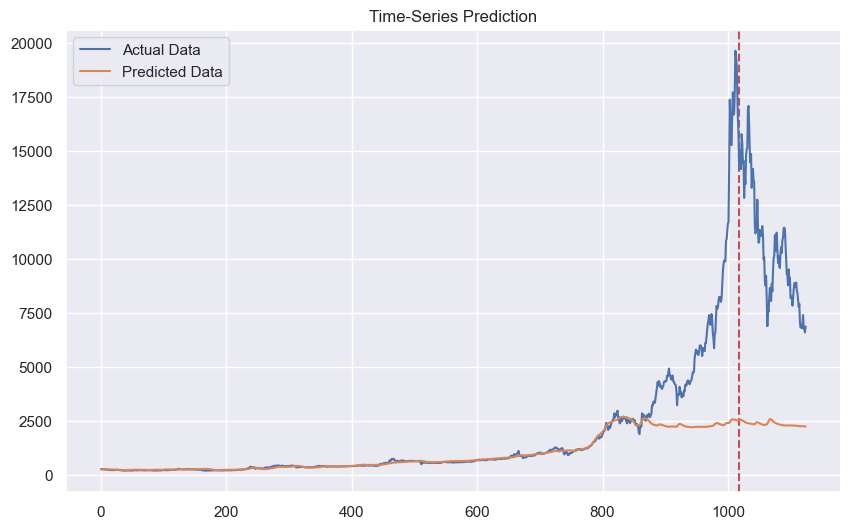

In [23]:
def plot_predictions(lstm, device):
    # Ensure your preprocessing tools like `ss` and `mm` are defined or passed to the function
    df_X_ss = ss.transform(df.drop(columns=['Close']))  # old transformers
    df_y_mm = mm.transform(df.Close.values.reshape(-1, 1))  # old transformers
    # split the sequence
    df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
    # converting to tensors
    df_X_ss = torch.Tensor(df_X_ss).to(device)
    df_y_mm = torch.Tensor(df_y_mm).to(device)
    # reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

    train_predict = lstm(df_X_ss)  # forward pass
    train_predict = train_predict.cpu()  # Move predictions back to CPU for numpy conversion

    data_predict = train_predict.data.numpy()  # numpy conversion
    dataY_plot = df_y_mm.cpu().data.numpy()

    data_predict = mm.inverse_transform(data_predict)  # reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)
    true, preds = [], []
    for i in range(len(dataY_plot)):
        true.append(dataY_plot[i][0])
    for i in range(len(data_predict)):
        preds.append(data_predict[i][0])

    plt.figure(figsize=(10,6))  # plotting
    plt.axvline(x=train_size, c='r', linestyle='--')  # size of the training set

    plt.plot(true, label='Actual Data')  # actual plot
    plt.plot(preds, label='Predicted Data')  # predicted plot
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.savefig("whole_plot.png", dpi=300)
    plt.show()

plot_predictions(lstm, device)

In [24]:
# salvando o modelo
torch.save(lstm.state_dict(), 'model.pth')

## Resultados do Teste `1`

```python
# percebemos um modelo que performou de forma exemplar em seus dados de treino, porém deixou muito a desejar nos dados de teste, portanto podemos visar uma melhoria do modelo ao aplicar estratégias para lidar com o overfit do mesmo.
```

#### `Overfit`

- Aumentar a quantidade de dados
- Diminuir a complexidade
- Early Stopping
- Dropout

---

## Segundo teste para sanar `Overfit`

```python

# Aqui utilizaremos a estratégia de aumentar a quantidade de dados de treinamento do modelo, visando reduzir o overfit, a arquitetura em si será a mesma

In [25]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.95)
X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [26]:
def instanciate_lstm(modelo,n_epochs,learning_rate, hidden_size, num_layers, dropout_rate=0.2):
    n_epochs = n_epochs # 1000 epochs
    learning_rate = learning_rate # 0.001 lr

    input_size = 5 # number of features
    hidden_size = hidden_size # number of features in hidden state
    num_layers = num_layers # number of stacked lstm layers

    num_classes = 50 # number of output classes 

    modelo = LSTM(
        num_classes, 
        input_size, 
        hidden_size, 
        num_layers,
        dropout_rate
    )
    
    return modelo, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes

def setup_optimizers(lstm, learning_rate):
    loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    return loss_fn, optimiser



In [27]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 3)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05431, test loss: 0.18882
Epoch: 100, train loss: 0.00372, test loss: 0.04133
Epoch: 200, train loss: 0.00198, test loss: 0.03553
Epoch: 300, train loss: 0.00111, test loss: 0.01634
Epoch: 400, train loss: 0.00087, test loss: 0.01101


KeyboardInterrupt: 

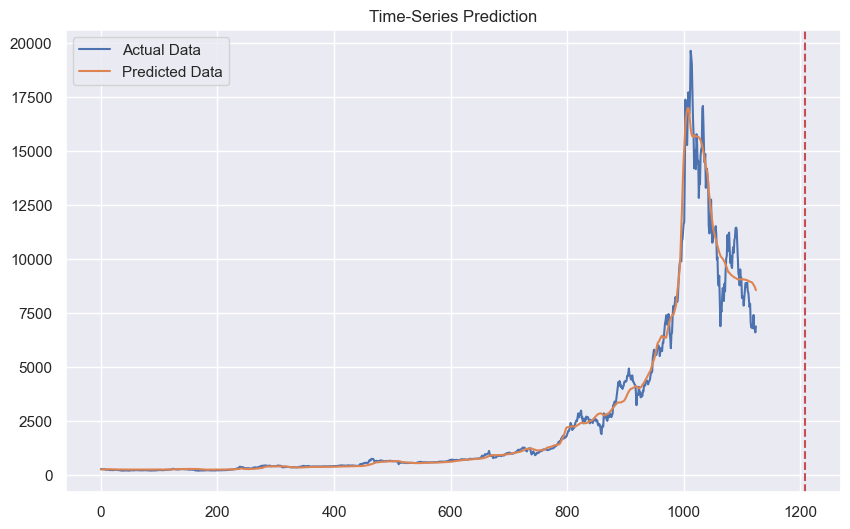

In [ ]:
plot_predictions(lstm, device)

---

## Testando a interferência do `num_layers`

```python

# Agora seria interessante ver como é afetado o comportamento do modelo ao alterar o hiperparâmetro de "num_layers"

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 7)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.06195, test loss: 0.20661
Epoch: 100, train loss: 0.01304, test loss: 0.00988
Epoch: 200, train loss: 0.00531, test loss: 0.03914
Epoch: 300, train loss: 0.00359, test loss: 0.04200
Epoch: 400, train loss: 0.00284, test loss: 0.04218
Epoch: 500, train loss: 0.00278, test loss: 0.03984
Epoch: 600, train loss: 0.00170, test loss: 0.01403
Epoch: 700, train loss: 0.00112, test loss: 0.00926
Epoch: 800, train loss: 0.00088, test loss: 0.00889
Epoch: 900, train loss: 0.00078, test loss: 0.00898


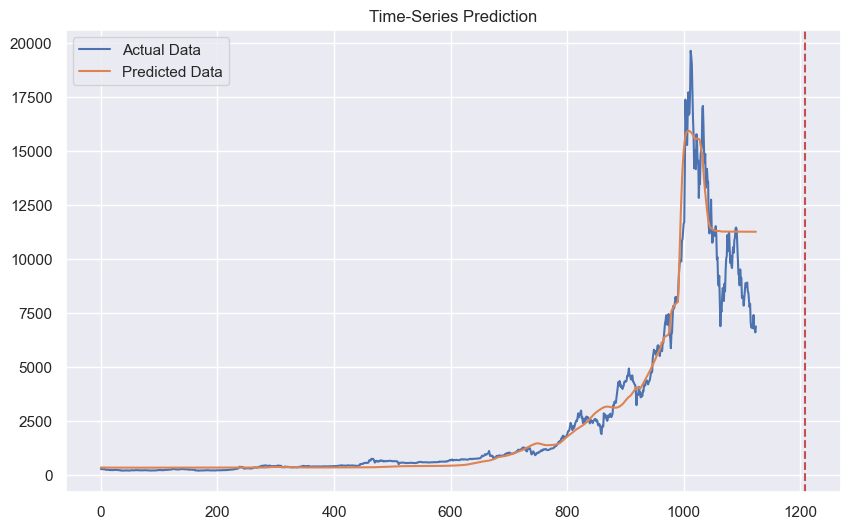

In [ ]:
plot_predictions(lstm, device)

## Aumentando ainda mais a quantidade de `num_layers`

```python

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05625, test loss: 0.19435
Epoch: 100, train loss: 0.00456, test loss: 0.04054
Epoch: 200, train loss: 0.00306, test loss: 0.04389
Epoch: 300, train loss: 0.00191, test loss: 0.03343
Epoch: 400, train loss: 0.00164, test loss: 0.02712
Epoch: 500, train loss: 0.00131, test loss: 0.02063
Epoch: 600, train loss: 0.00107, test loss: 0.01426
Epoch: 700, train loss: 0.00090, test loss: 0.01043
Epoch: 800, train loss: 0.00077, test loss: 0.00746
Epoch: 900, train loss: 0.00068, test loss: 0.00659


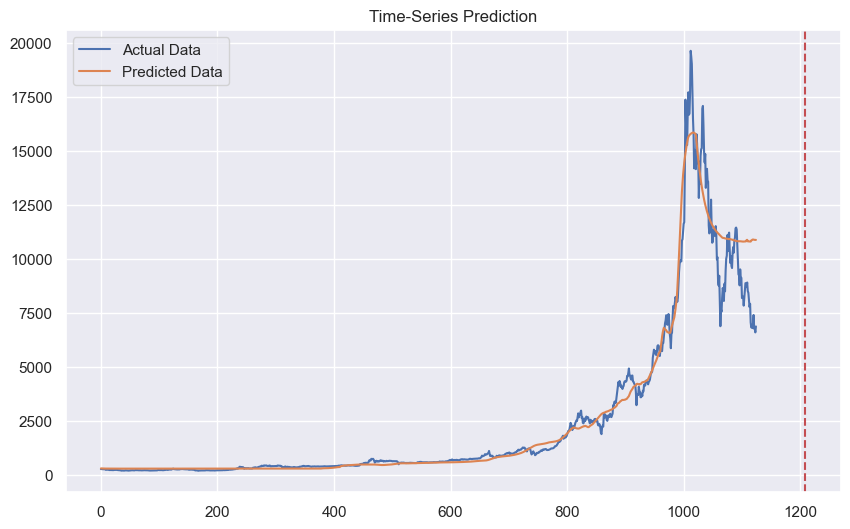

In [ ]:
plot_predictions(lstm, device)

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 10)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05755, test loss: 0.19423
Epoch: 100, train loss: 0.03509, test loss: 0.10863
Epoch: 200, train loss: 0.01716, test loss: 0.02712
Epoch: 300, train loss: 0.00508, test loss: 0.03516
Epoch: 400, train loss: 0.00325, test loss: 0.04449
Epoch: 500, train loss: 0.00280, test loss: 0.04078
Epoch: 600, train loss: 0.00271, test loss: 0.04040
Epoch: 700, train loss: 0.00254, test loss: 0.03982
Epoch: 800, train loss: 0.00248, test loss: 0.03941
Epoch: 900, train loss: 0.00240, test loss: 0.04053


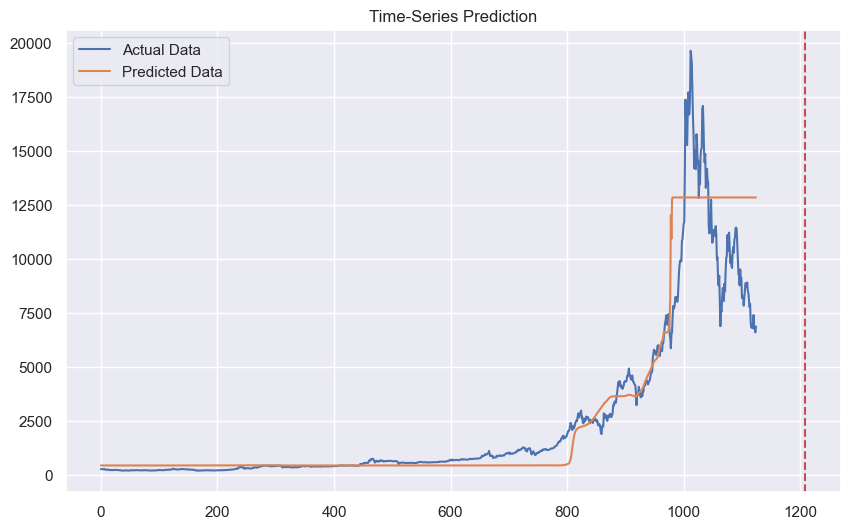

In [ ]:
plot_predictions(lstm, device)

Aumentando o dropout

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 10, 0.4)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05640, test loss: 0.20126
Epoch: 100, train loss: 0.03509, test loss: 0.10858
Epoch: 200, train loss: 0.03495, test loss: 0.10804
Epoch: 300, train loss: 0.00620, test loss: 0.04065
Epoch: 400, train loss: 0.00428, test loss: 0.04225
Epoch: 500, train loss: 0.00300, test loss: 0.04204
Epoch: 600, train loss: 0.00289, test loss: 0.04426
Epoch: 700, train loss: 0.00286, test loss: 0.04175
Epoch: 800, train loss: 0.00289, test loss: 0.04210
Epoch: 900, train loss: 0.00269, test loss: 0.04203


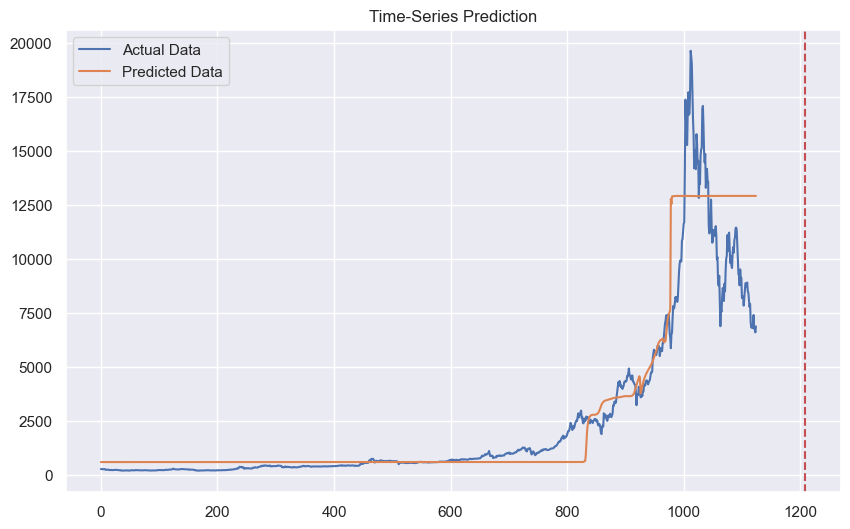

In [ ]:
plot_predictions(lstm, device)

### alterando o hidden_size

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 15, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05140, test loss: 0.17797
Epoch: 100, train loss: 0.00423, test loss: 0.03885
Epoch: 200, train loss: 0.00198, test loss: 0.03230
Epoch: 300, train loss: 0.00152, test loss: 0.02563
Epoch: 400, train loss: 0.00100, test loss: 0.01139
Epoch: 500, train loss: 0.00078, test loss: 0.00661
Epoch: 600, train loss: 0.00073, test loss: 0.00642
Epoch: 700, train loss: 0.00070, test loss: 0.00616
Epoch: 800, train loss: 0.00063, test loss: 0.00641
Epoch: 900, train loss: 0.00059, test loss: 0.00655


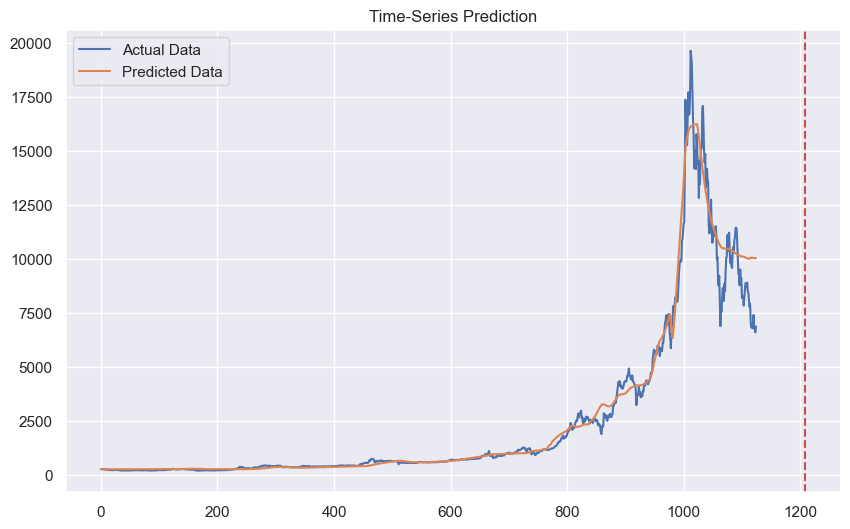

In [ ]:
plot_predictions(lstm, device)

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 20, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05547, test loss: 0.19784
Epoch: 100, train loss: 0.00572, test loss: 0.04133
Epoch: 200, train loss: 0.00281, test loss: 0.03569
Epoch: 300, train loss: 0.00097, test loss: 0.01103
Epoch: 400, train loss: 0.00075, test loss: 0.01063
Epoch: 500, train loss: 0.00060, test loss: 0.03931
Epoch: 600, train loss: 0.00052, test loss: 0.04222
Epoch: 700, train loss: 0.00045, test loss: 0.04649
Epoch: 800, train loss: 0.00041, test loss: 0.05105
Epoch: 900, train loss: 0.00041, test loss: 0.05762


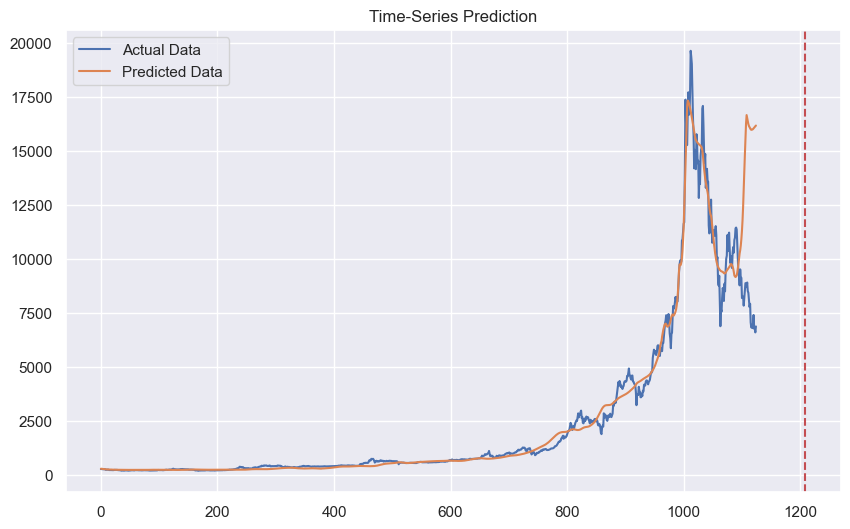

In [ ]:
plot_predictions(lstm, device)

### Testando diferentes distribuições dos dados

In [ ]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.80)
X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 15, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.00947, test loss: 0.23195
Epoch: 100, train loss: 0.00036, test loss: 0.13674
Epoch: 200, train loss: 0.00011, test loss: 0.12213
Epoch: 300, train loss: 0.00006, test loss: 0.10279
Epoch: 400, train loss: 0.00005, test loss: 0.10330
Epoch: 500, train loss: 0.00005, test loss: 0.10215
Epoch: 600, train loss: 0.00004, test loss: 0.10249
Epoch: 700, train loss: 0.00004, test loss: 0.10242
Epoch: 800, train loss: 0.00003, test loss: 0.10183
Epoch: 900, train loss: 0.00003, test loss: 0.10270


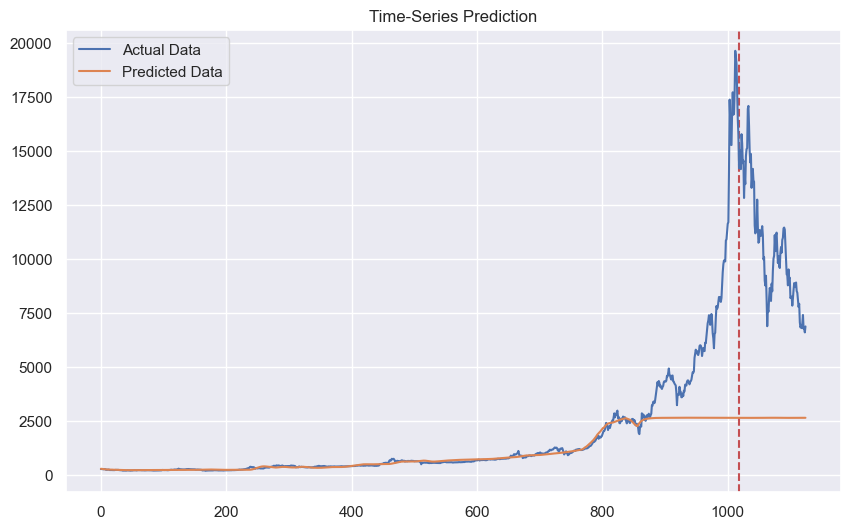

In [ ]:
plot_predictions(lstm, device)

In [ ]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.90)
X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [ ]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 15, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.03035, test loss: 0.26005
Epoch: 100, train loss: 0.00363, test loss: 0.12719
Epoch: 200, train loss: 0.00075, test loss: 0.13607
Epoch: 300, train loss: 0.00054, test loss: 0.10112
Epoch: 400, train loss: 0.00046, test loss: 0.09860
Epoch: 500, train loss: 0.00042, test loss: 0.09721
Epoch: 600, train loss: 0.00036, test loss: 0.09925
Epoch: 700, train loss: 0.00031, test loss: 0.10181
Epoch: 800, train loss: 0.00029, test loss: 0.10435
Epoch: 900, train loss: 0.00026, test loss: 0.10335


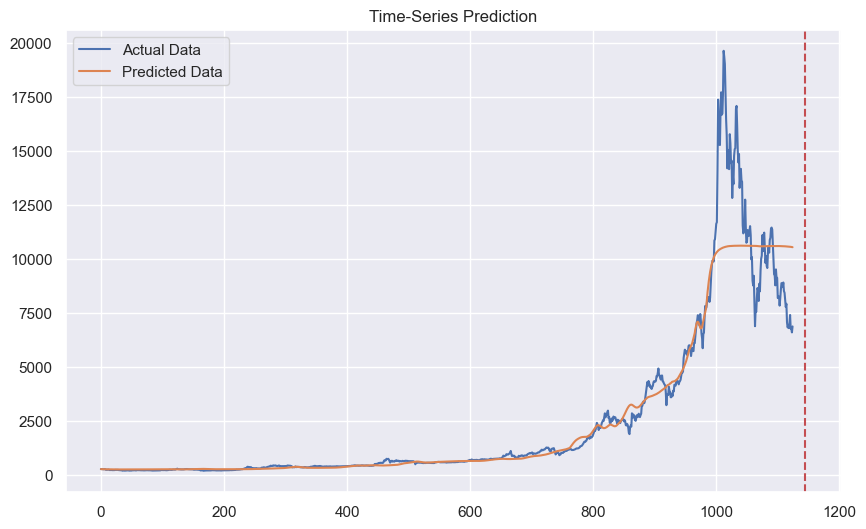

In [ ]:
plot_predictions(lstm, device)

## Testes com diferentes tamanhos de Janela

### Alternado a faixa de entrada

In [43]:
def preprocessing(X_train, X_test, y_train, y_test, window_size):
    X_train_tensors = torch.Tensor(X_train)
    X_test_tensors = torch.Tensor(X_test)

    y_train_tensors = torch.Tensor(y_train)
    y_test_tensors = torch.Tensor(y_test)

    X_train_tensors.requires_grad = True
    X_test_tensors.requires_grad = True

    y_train_tensors.requires_grad = True
    y_test_tensors.requires_grad = True

    X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], window_size, X_train_tensors.shape[2]))
    X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], window_size, X_test_tensors.shape[2]))

    return X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors

def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        loss = torch.nn.MSELoss()(y_pred, y_test)
    return loss.item()

In [34]:
results = []

window_sizes = [50, 75, 100, 125, 150]  # diferentes tamanhos de janela para testar
n_steps_out = 50

for window_size in window_sizes:
    print(f"Testing window size: {window_size}")
    # Preparar os dados com o tamanho de janela atual
    X_ss, y_mm = split_sequences(X_scaled, y_scaled, window_size, n_steps_out)
    
    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test, train_size, test_size = divisao_treino(0.80)
    X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test, window_size, n_steps_out)
    
    # Instanciar e treinar o modelo
    lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 400, 0.001, 15, 5)
    loss_fn, optimiser = setup_optimizers(lstm, learning_rate)
    
    training_loop(n_epochs=n_epochs,
                  lstm=lstm,
                  optimiser=optimiser,
                  loss_fn=loss_fn,
                  X_train=X_train_tensors_final,
                  y_train=y_train_tensors,
                  X_test=X_test_tensors_final,
                  y_test=y_test_tensors,
                  device=device)
    
    # Avaliar e armazenar os resultados
    performance = evaluate_model(lstm, X_test_tensors_final, y_test_tensors, device)
    results.append((window_size, performance))

# Imprimir os resultados
for window_size, performance in results:
    print(f"Window size: {window_size}, Performance: {performance}")


Testing window size: 50
Epoch: 0, train loss: 0.00837, test loss: 0.22730
Epoch: 100, train loss: 0.00061, test loss: 0.15864
Epoch: 200, train loss: 0.00010, test loss: 0.09755
Epoch: 300, train loss: 0.00006, test loss: 0.10401
Testing window size: 75
Epoch: 0, train loss: 0.00651, test loss: 0.22226
Epoch: 100, train loss: 0.00039, test loss: 0.12967
Epoch: 200, train loss: 0.00010, test loss: 0.10198
Epoch: 300, train loss: 0.00007, test loss: 0.10375
Testing window size: 100
Epoch: 0, train loss: 0.00861, test loss: 0.22094
Epoch: 100, train loss: 0.00049, test loss: 0.13541
Epoch: 200, train loss: 0.00018, test loss: 0.10935
Epoch: 300, train loss: 0.00006, test loss: 0.10494
Testing window size: 125
Epoch: 0, train loss: 0.00872, test loss: 0.23386
Epoch: 100, train loss: 0.00152, test loss: 0.19937
Epoch: 200, train loss: 0.00011, test loss: 0.11305
Epoch: 300, train loss: 0.00006, test loss: 0.10352
Testing window size: 150
Epoch: 0, train loss: 0.01167, test loss: 0.23833
Epo